<a href="https://colab.research.google.com/github/dangalmar/TFG_Imagenes_Medicas/blob/main/Tratamiento_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [4]:
folder_benign_train = '../../new_data/train/benign'
folder_malignant_train = '../../new_data/train/malignant'

folder_benign_test = '../../new_data/test/benign'
folder_malignant_test = '../../new_data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

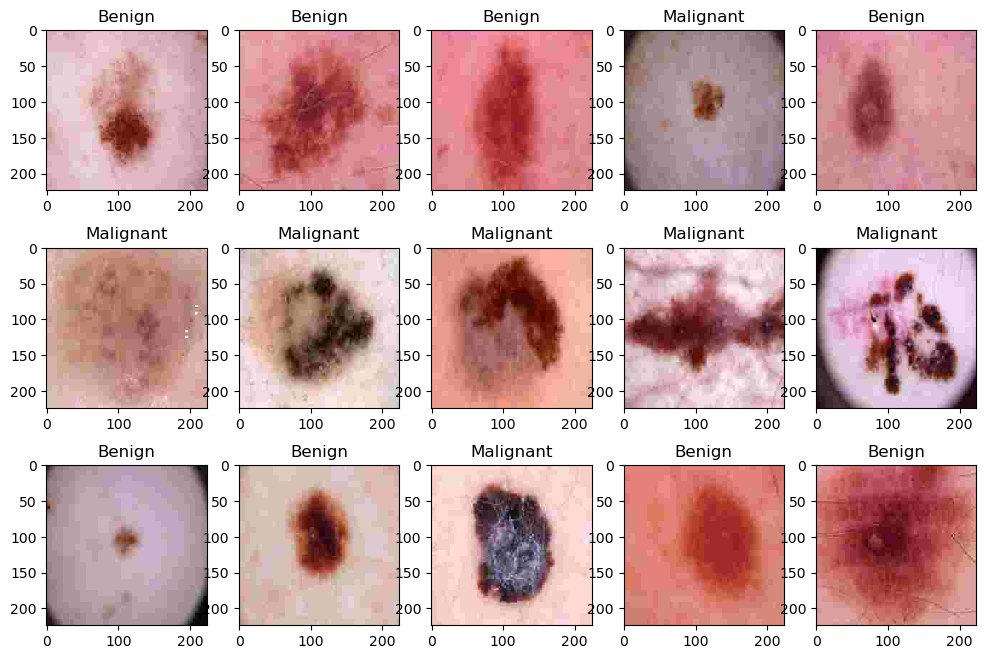

In [5]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')

plt.show()

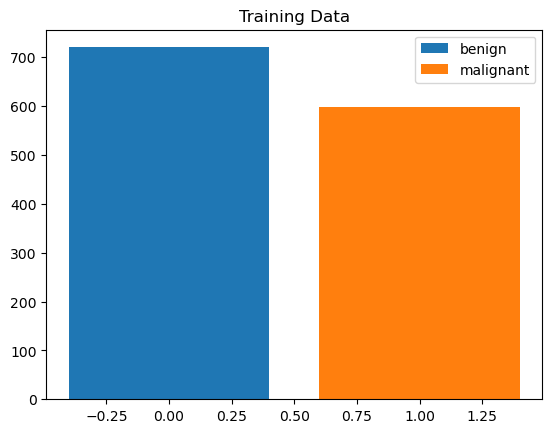

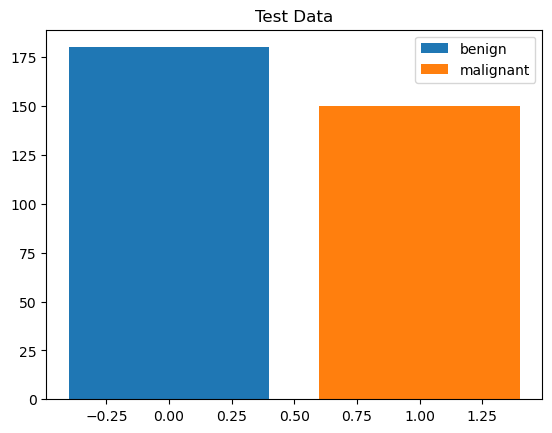

In [6]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [18]:
from keras.preprocessing.image import ImageDataGenerator

# Crear un generador de aumento de datos para las imágenes de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalizar los valores de píxeles
    rotation_range=40,          # Rango de rotación aleatorio
    width_shift_range=0.2,      # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,     # Desplazamiento vertical aleatorio
    shear_range=0.2,            # Distorsión de cizalla aleatoria
    zoom_range=0.2,             # Zoom aleatorio
    horizontal_flip=True,       # Volteo horizontal aleatorio
    fill_mode='nearest'         # Modo de relleno para los píxeles que faltan después de la transformación
)

# Crear un generador de aumento de datos para las imágenes de validación (solo normalización)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Configurar los generadores de flujo de datos
train_generator = train_datagen.flow(
    X_train, y_train,           # Datos de entrenamiento
    batch_size=32              # Tamaño del lote
)

validation_generator = validation_datagen.flow(
    X_test, y_test,             # Datos de validación
    batch_size=32
)


In [19]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (224,224,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))

# Bloack 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))

# Output layer
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 128)     

In [20]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_annealer = ReduceLROnPlateau(monitor='val_acc',mode='max',
                                          patience=3,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr = 1e-4)


history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // 32,
                    validation_split=0.2,
                    epochs=100,
                    batch_size = 64,
                    verbose=1,
                    callbacks=[learning_rate_annealer],
                    validation_data=validation_generator,
                    validation_steps=len(X_test) // 32 )



print(history.history.keys())

Epoch 1/100
41/41 [==============================] - 53s 1s/step - loss: 0.8121 - accuracy: 0.5591 - val_loss: 0.5913 - val_accuracy: 0.6656 - lr: 0.0010
Epoch 2/100
41/41 [==============================] - 52s 1s/step - loss: 0.6170 - accuracy: 0.7068 - val_loss: 0.6367 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 3/100
41/41 [==============================] - 52s 1s/step - loss: 0.5411 - accuracy: 0.7294 - val_loss: 0.5234 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/100
41/41 [==============================] - 53s 1s/step - loss: 0.5454 - accuracy: 0.7341 - val_loss: 0.5644 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 5/100
41/41 [==============================] - 52s 1s/step - loss: 0.4895 - accuracy: 0.7691 - val_loss: 0.4947 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 6/100
41/41 [==============================] - 51s 1s/step - loss: 0.4847 - accuracy: 0.7644 - val_loss: 0.4786 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 7/100
41/41 [==============================] - 57s 1s/step - loss: 0.4

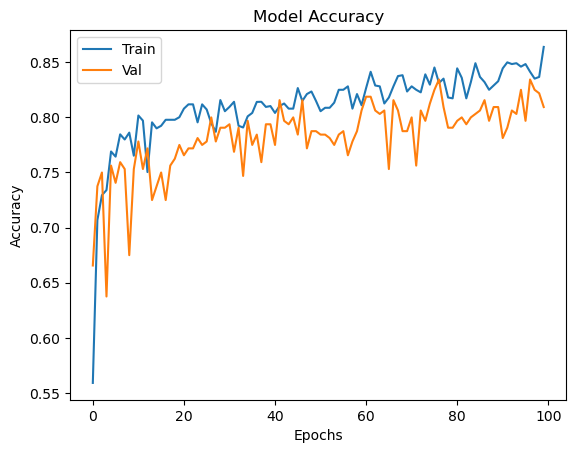

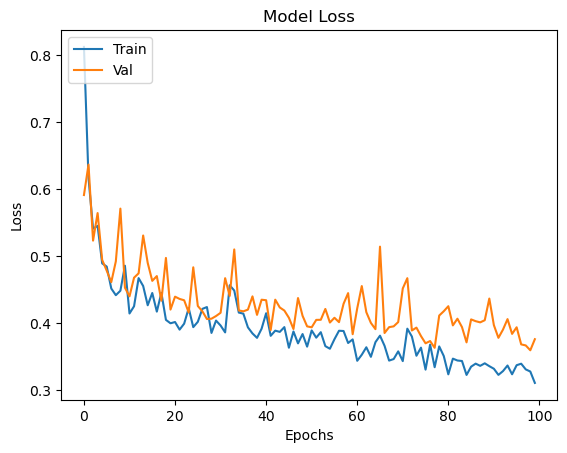

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()